# Inference on "Data"

* The purpose of this notebook is to allow for evaluation/sampling with a trained NF model on sector_scint data  
* We also compare the samples to real data (sector_sensor)

## Setup
**Package imports:**

In [1]:
# Import packages
import torch
import numpy as np
import normflows as nf

import uproot as up

from matplotlib import pyplot as plot
import math
from tqdm import tqdm
from IPython.display import clear_output
import time
from concurrent.futures import ThreadPoolExecutor
import matplotlib.ticker as plticker
import os
from typing import Union, List

**local imports (written by me):**

In [2]:
from reco import process_data, create_dataloader, prepare_data_for_nn, create_dataloader,create_unique_mapping,calculate_num_pixels_z_dependence
from util import PVect, theta_func, r_func,get_layer, create_layer_map,load_real_data

Using device cuda:0


In [3]:
# Get device to be used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
import os
def checkdir(path):
    if not os.path.exists(path): 
        os.makedirs(path)

### Set parameters of model and data

In [5]:
import datetime
x = datetime.datetime.now()
today = x.strftime("%B_%d")

In [6]:
# particle = "pi"
particle = "mu"

# This data will be used for storing plots - today above works if you actually want today
# today = "July_26"

run_num = 7
run_num_str = str(run_num)

#NF Stuff

K = 8 #num flows

latent_size = 1 #dimension of PDF
hidden_units = 256 #nodes in hidden layers
hidden_layers = 26
context_size = 3 #conditional variables for PDF
num_context = 3

K_str = str(K)
batch_size= 2000
hidden_units_str = str(hidden_units)
hidden_layers_str = str(hidden_layers)
batch_size_str = str(batch_size)

## Neural Spline Flow
model definition:

In [7]:
flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units, 
                                                             num_context_channels=context_size)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set base distribution
q0 = nf.distributions.DiagGaussian(1, trainable=False)
    
# Construct flow model
model = nf.ConditionalNormalizingFlow(q0, flows)

# Move model on GPU if available
model = model.to(device)


Create directories / pick where to pull from

In [8]:
# model_date = "August_03"
# today = "August_03"
# model_path = "models/" + model_date + "/"
# checkdir(model_path)

model_path = "/hpc/group/vossenlab/rck32/NF_time_res_models/"

samples_path = "data/samples/" + today + "/"
checkdir(samples_path)

test_data_path = "data/test/" + today + "/"
checkdir(test_data_path)

test_dist_path = "plots/test_distributions/" + today + "/"
checkdir(test_dist_path)

Load model accoring to params above

In [9]:
model.load(model_path + "run_" + run_num_str + "_" + str(num_context)+ "context_" +K_str +  "flows_" + hidden_layers_str+"hl_" + hidden_units_str+"hu_" + batch_size_str+"bs.pth")
model = model.to(device)

/hpc/group/vossenlab/rck32/ML_venv/lib64/python3.9/site-packages/normflows/core.py:213: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


In [10]:
model_compile = torch.compile(model,mode = "reduce-overhead")
model_compile = model_compile.to(device)

### Evaluation
load sector_scint root files with uproot

In [11]:
'''muons'''
# up_path = f"/cwork/rck32/eic/work_eic/root_files/July_25/sector_scint/run_1_mu_5GeV_theta_vary_10kevents.edm4hep.root:events"
'''pions'''
# up_path = f"/cwork/rck32/eic/work_eic/root_files/July_25/sector_scint/run_1_pi_5GeV_theta_vary_1kevents.edm4hep.root:events"

# data = process_data(up_path)

'pions'

In [12]:
'''muon z pos vary'''

# Specify the directory path
directory = f"/hpc/group/vossenlab/rck32/eic/work_eic/root_files/August_28/sector_scint/run_1/"

# List to store loaded tensors
times = []

# Loop through all files in the directory
for filename in os.listdir(directory):
    # Construct full file path
    file_path = os.path.join(directory, filename)
    
    # Check if it's a file (not a subdirectory)
    if os.path.isfile(file_path):
        # Load the tensor from the file
        tensor = process_data(file_path + ":events")
        
        # Append the tensor to our list
        times.append(tensor)
        
        

In [36]:
from reco import super_layer_map
def process_data(uproot_path, file_num=0, particle="pion"):
    num_layers = 28
    data = []
    events = up.open(uproot_path)
    
    x_pos_branch = events["HcalBarrelHits/HcalBarrelHits.position.x"].array(library='np')
    z_pos_branch = events["HcalBarrelHits/HcalBarrelHits.position.z"].array(library='np')
    EDep_branch = events["HcalBarrelHits.EDep"].array(library='np')
    PDG_branch = events["MCParticles.PDG"].array(library='np')
    x_momentum_branch = events["HcalBarrelHits/HcalBarrelHits.momentum.x"].array(library='np')
    y_momentum_branch = events["HcalBarrelHits/HcalBarrelHits.momentum.y"].array(library='np')
    z_momentum_branch = events["HcalBarrelHits/HcalBarrelHits.momentum.z"].array(library='np')
    Hits_MC_idx_branch = events["_HcalBarrelHits_MCParticle.index"].array(library='np')
    time_branch = events["HcalBarrelHits.time"].array(library='np')   
    num_events = len(x_pos_branch)
    for event_idx in range(num_events):
        Hits_MC_idx_event = Hits_MC_idx_branch[event_idx]
        PDG_event = PDG_branch[event_idx]
        n_unique_parts, idx_dict = create_unique_mapping(Hits_MC_idx_event)
        
        p_layer_list = np.ones((num_layers,n_unique_parts)) * -999
        z_hit_layer_list = np.ones((num_layers,n_unique_parts)) * -999
        theta_layer_list = np.ones((num_layers,n_unique_parts)) * -999
        hit_time_layer_list = np.ones((num_layers,n_unique_parts)) * -999
        edep_event = np.ones((num_layers,n_unique_parts)) * -999
        PDG_list = np.ones((num_layers,n_unique_parts)) * -999
        
        x_pos_event = x_pos_branch[event_idx]
        px_event = x_momentum_branch[event_idx]
        py_event = y_momentum_branch[event_idx]
        pz_event = z_momentum_branch[event_idx]
        z_event = z_pos_branch[event_idx]
        time_event = time_branch[event_idx]
        EDep_event = EDep_branch[event_idx]
        for hit_idx in range(len(x_pos_event)):
            idx = Hits_MC_idx_branch[event_idx][hit_idx]
            part_idx = idx_dict[idx]
            layer_idx = get_layer(x_pos_event[hit_idx], super_layer_map)
            if layer_idx == -1: #error handling for get_layer
                continue
            elif p_layer_list[layer_idx,part_idx] == -999:
                p_layer_list[layer_idx,part_idx] = np.sqrt(px_event[hit_idx]**2 + py_event[hit_idx]**2 + pz_event[hit_idx]**2)
                z_hit_layer_list[layer_idx,part_idx] = z_event[hit_idx]
                theta_layer_list[layer_idx,part_idx] = np.arctan2(np.sqrt(px_event[hit_idx]**2 + py_event[hit_idx]**2), pz_event[hit_idx])
                hit_time_layer_list[layer_idx,part_idx] = time_event[hit_idx]
                edep_event[layer_idx,part_idx] = EDep_event[hit_idx]
                PDG_list[layer_idx,part_idx] = PDG_event[part_idx]
            else:
                edep_event[layer_idx,part_idx] += EDep_event[hit_idx]
        for i in range(len(edep_event)):
            for j in range(len(edep_event[i])):
                print(f"layer:\t\t{i}\t|\tparticle id:\t{j}\t|\tnum_pixels:\t{calculate_num_pixels_z_dependence(edep_event[i,j],z_hit_layer_list[i,j])}")
        data.append(np.stack([z_hit_layer_list,theta_layer_list,p_layer_list,hit_time_layer_list,(np.floor(calculate_num_pixels_z_dependence(edep_event,z_hit_layer_list)).astype(int))],axis = -1))


    
    return data #returns list: each entry is a diff event array; each event array has shape: (#unique particles, #layers, #features)
                #features: z hit, hit time, theta, p, energy dep

Put data in useable format (functions from reco.py)  
Note: metadata format
1. event idx
1. particle idx
1. layer idx

In [16]:
features, metadata= prepare_data_for_nn(times[0])
print("Features shape:", features.shape)
print("Metadata shape:", metadata.shape)

# Create DataLoader
batch_size_inference = 1000000
dataloader = create_dataloader(features, metadata, batch_size_inference)

len of events: 500
Features shape: (1483869, 4)
Metadata shape: (1483869, 3)
(1483869, 4)


### Resampling inference with dataloader
Use this to make sure every photon time is reasonable - this is more accurate but slower

In [17]:

# min_time = 0
# samples = torch.empty(features.shape[0],device = device)
# it = 0
# begin_time = time.time()
# for batch_features, batch_metadata in dataloader:
#     begin = batch_size * it
#     end = batch_size * (it + 1)
#     # Initialize a mask for valid samples
#     batch_features = batch_features.to(device)
#     valid_samples = torch.zeros(batch_features.shape[0], dtype=torch.bool,device = device)
#     batch_samples = torch.empty(batch_features.shape[0],device = device)
    
#     while not valid_samples.all():
#         # Generate samples for the invalid positions
#         new_samples = model.sample(num_samples=(~valid_samples).sum(), context=batch_features[~valid_samples])[0].squeeze(1)
        
#         # Update the samples and the valid_samples mask
#         batch_samples[~valid_samples] = new_samples
#         valid_samples = batch_samples >= min_time
    
#     samples[begin:end] = batch_samples
#     it += 1
#     if(it >= 0):
#         break
# end_time = time.time()
# samples_cpu = samples.cpu()

### No resampling

In [14]:
# with torch.profiler.profile(activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA]) as prof:
min_time = 0
samples = torch.empty(features.shape[0],device = device)
hit_times = torch.empty(features.shape[0],device = device)
layer_idxs = torch.empty(features.shape[0],device = device)
event_idxs = torch.empty(features.shape[0],device = device)
it = 0
begin_time = time.time()
with torch.no_grad():
    for batch_features, batch_metadata in dataloader:
        print(f"beginning batch #{it} of {int(np.floor(len(features) / batch_size_inference))}")
        context_features = batch_features[:, :3].clone().to(device)
        context_features[:, 1] *= 180 / 3.14159
        samples[batch_size_inference * it:(batch_size_inference * it) + len(batch_features)] = abs(model_compile.sample(num_samples=context_features.shape[0], context=context_features)[0]).squeeze(1)
        samples[it*batch_size_inference:(batch_size_inference * it) + len(batch_features)].add_(batch_features[:, 3].to(device))
        hit_times[batch_size_inference * it:(batch_size_inference * it) + len(batch_features)] = batch_features[:,3]
        layer_idxs[batch_size_inference * it:(batch_size_inference * it) + len(batch_features)] = batch_metadata[:,2]
        event_idxs[batch_size_inference * it:(batch_size_inference * it) + len(batch_features)] = batch_metadata[:,0]
        del batch_features
        it += 1
#         if(it > 5):
#             break
#         break
end_time = time.time()

beginning batch #0 of 58
beginning batch #1 of 58
beginning batch #2 of 58
beginning batch #3 of 58
beginning batch #4 of 58
beginning batch #5 of 58
beginning batch #6 of 58
beginning batch #7 of 58
beginning batch #8 of 58
beginning batch #9 of 58
beginning batch #10 of 58
beginning batch #11 of 58
beginning batch #12 of 58
beginning batch #13 of 58
beginning batch #14 of 58
beginning batch #15 of 58
beginning batch #16 of 58
beginning batch #17 of 58
beginning batch #18 of 58
beginning batch #19 of 58
beginning batch #20 of 58
beginning batch #21 of 58
beginning batch #22 of 58
beginning batch #23 of 58
beginning batch #24 of 58
beginning batch #25 of 58
beginning batch #26 of 58
beginning batch #27 of 58
beginning batch #28 of 58
beginning batch #29 of 58
beginning batch #30 of 58
beginning batch #31 of 58
beginning batch #32 of 58
beginning batch #33 of 58
beginning batch #34 of 58
beginning batch #35 of 58
beginning batch #36 of 58
beginning batch #37 of 58
beginning batch #38 of

In [15]:
samples_cpu = samples.cpu().detach()
hit_times_cpu = hit_times.cpu().detach()
layer_idxs_cpu = layer_idxs.cpu().detach()
event_idxs_cpu = event_idxs.cpu().detach()
# print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

We can evaluate how long the inference took:

In [16]:
delta_t = end_time - begin_time

print(f"Sampling {(batch_size_inference * it)} times took {(delta_t)} seconds\n rate: {((batch_size_inference * it)) / (delta_t)} samples/second")

Sampling 59000000 times took 1334.4644904136658 seconds
 rate: 44212.491545362 samples/second


**compiled: 112k per second at 1m batch size**  
**non-compiled: 114k per second at 1m batch size**

Save sampled times

In [17]:
torch.save(samples_cpu,samples_path+"August_28_mu_5k_samples.pt")
torch.save(layer_idxs_cpu,samples_path+"August_28_mu_5k_layers.pt")
torch.save(event_idxs_cpu,samples_path+"August_28_mu_5k_events.pt")
# torch.save(hit_idx_max,samples_path+"August_28_mu_5k_hit_idx_max.pt")

NameError: name 'hit_idx_max' is not defined

## Load in and compare to real data

In [83]:
file_dir = f"/cwork/rck32/eic/work_eic/root_files/July_25/sector_sensor/pi/"
truth_times = load_real_data(file_dir)

Processed 3047025 hits


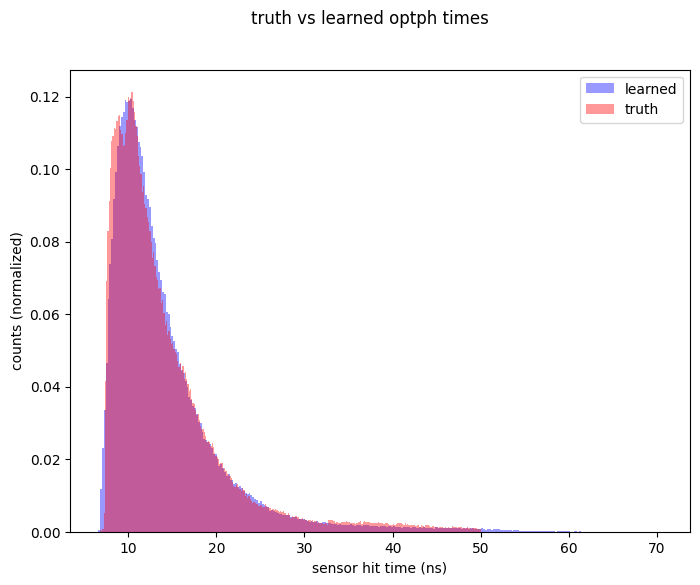

In [89]:
comp_fig, comp_axs = plot.subplots(1,1,figsize = (8,6))
comp_fig.suptitle("truth vs learned optph times")
comp_axs.hist(abs(samples_cpu[:500000]),bins = 300,density = True,color = "blue", alpha = 0.4,label = "learned")
comp_axs.set_xlabel("sensor hit time (ns)")
comp_axs.set_ylabel("counts (normalized)")
comp_axs.hist(truth_times[:500000][:,0],bins = 300,density = True, color = "red", alpha = 0.4,label = "truth");
comp_axs.legend();
# comp_fig.savefig("plots/truth_comp/pi_july_25_run_1_full_theta.jpeg")

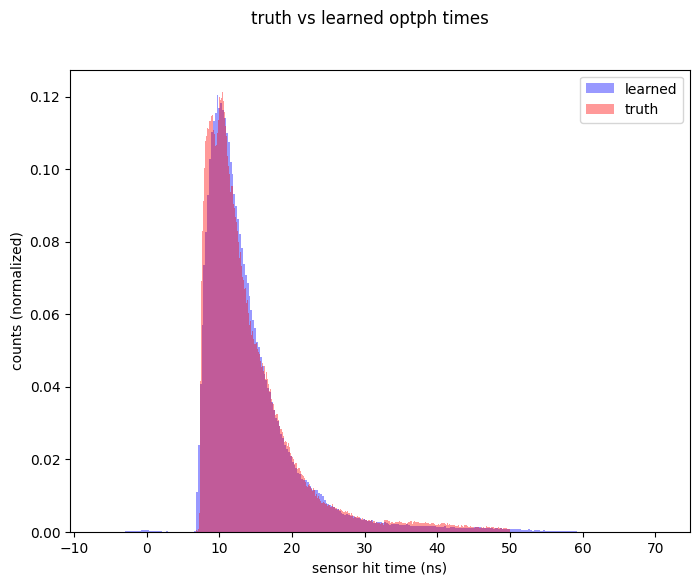

In [85]:
comp_fig, comp_axs = plot.subplots(1,1,figsize = (8,6))
comp_fig.suptitle("truth vs learned optph times")
comp_axs.hist(samples_cpu[:500000],bins = 300,density = True,color = "blue", alpha = 0.4,label = "learned")
comp_axs.set_xlabel("sensor hit time (ns)")
comp_axs.set_ylabel("counts (normalized)")
comp_axs.hist(truth_times[:500000][:,0],bins = 300,density = True, color = "red", alpha = 0.4,label = "truth");
comp_axs.legend();
# comp_fig.savefig("plots/truth_comp/pi_july_25_run_1_full_theta.jpeg")

Avoid large histograms by cutting down data to 500k events

In [31]:
samples_short = samples_cpu[:500000]
layer_idxs_short = layer_idxs_cpu[:500000]
hit_times_short = hit_times_cpu[:500000]

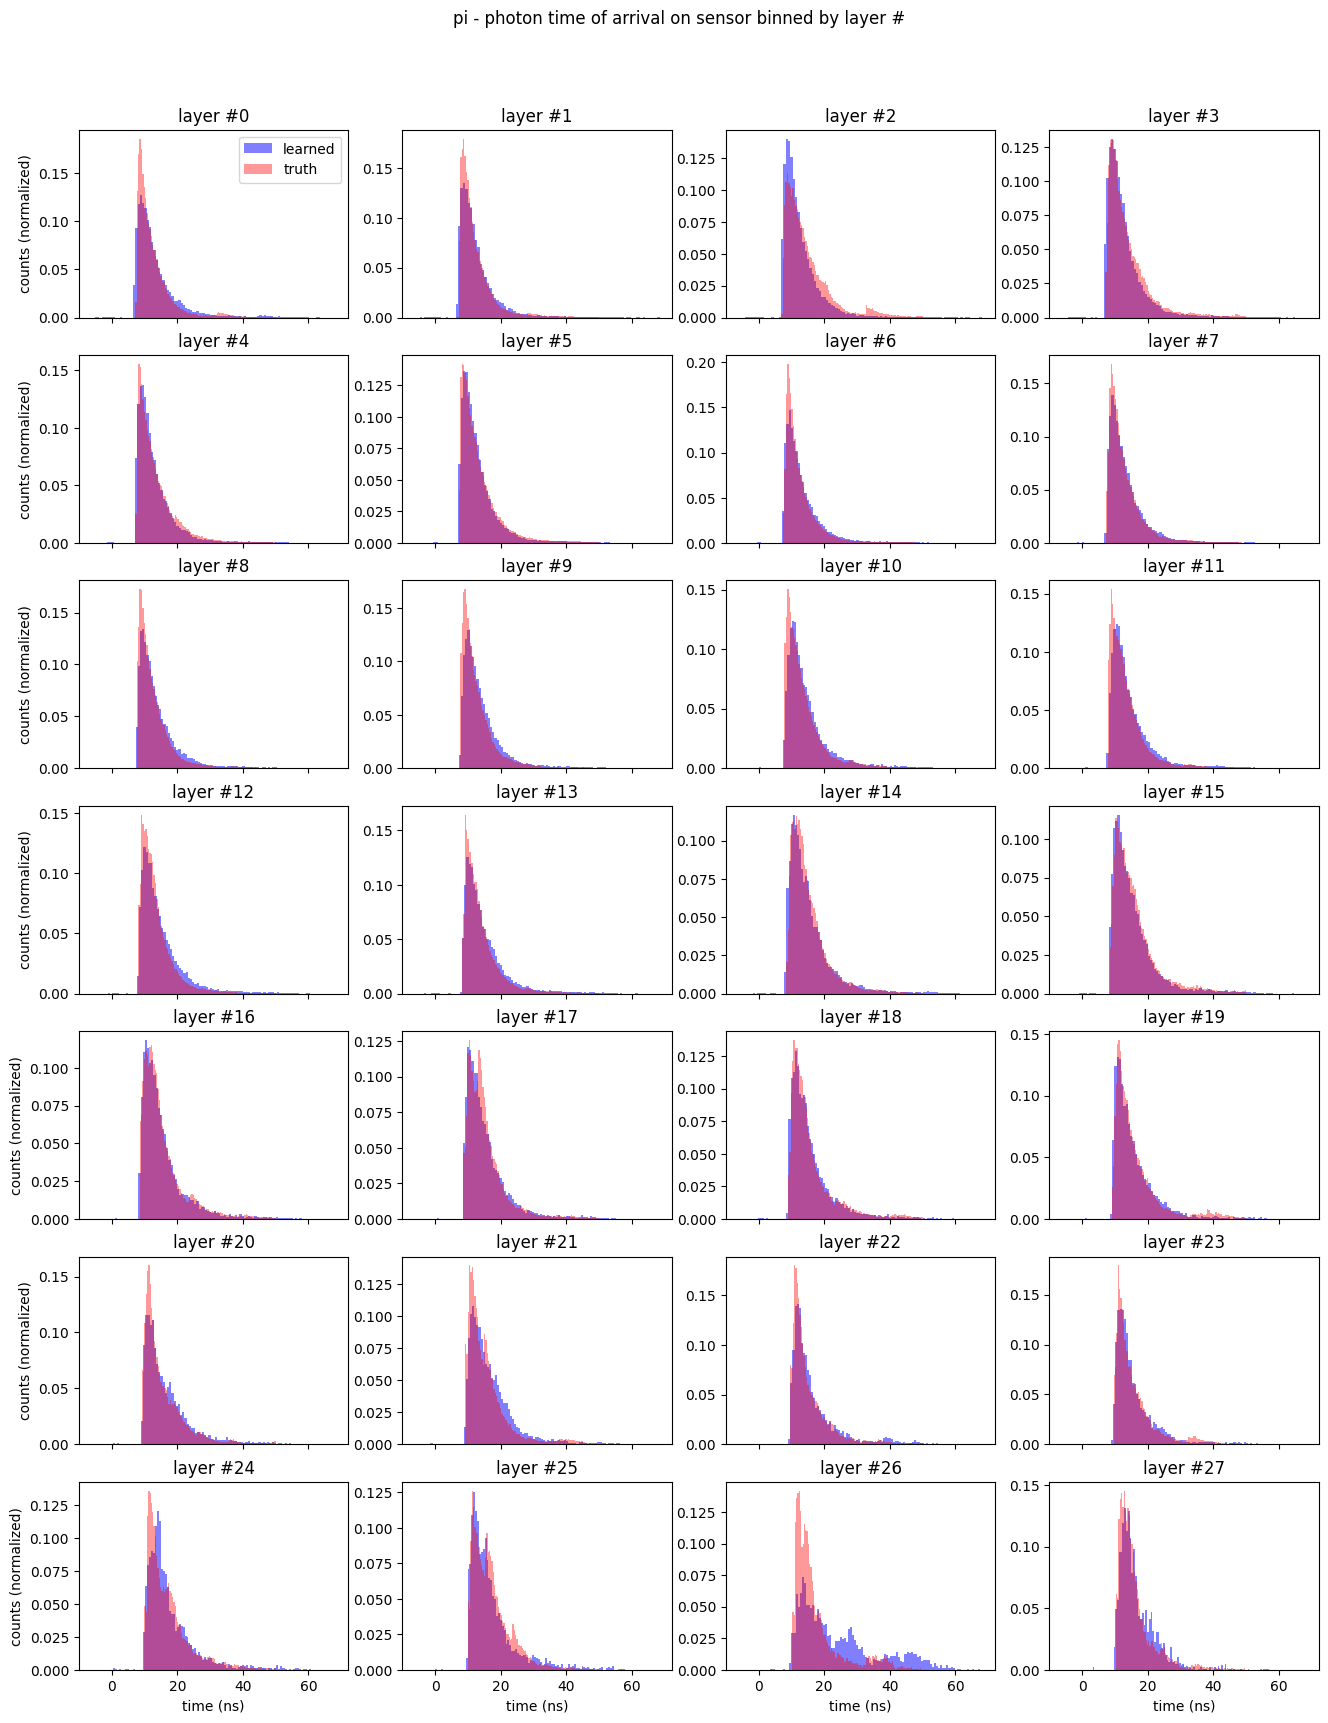

In [32]:
layer_fig, layer_axs = plot.subplots(7,4,figsize=(16,20),sharex=True)
for i in range(7):
    for j in range(4):
        curr_layer = i * 4 + j
        curr_samples = samples_short[layer_idxs_short == curr_layer]#select hits in ith layer
        curr_hit_times = hit_times_short[layer_idxs_short == curr_layer]#select hits in ith layer
        curr_truth = truth_times[truth_times[:,1] == curr_layer][:,0]
        layer_fig.suptitle("pi - photon time of arrival on sensor binned by layer #",y = 0.94)
        layer_axs[i][j].hist(curr_samples,density = True, bins = 100,color = "blue",alpha = 0.5,label = "learned")
        layer_axs[i][j].hist(curr_truth,density = True, bins = 100, color = "red",alpha = 0.4,label = "truth")
        layer_axs[i][j].set_title(f"layer #{curr_layer}")
        if(i == 0 and j == 0):
            layer_axs[i][j].legend()
        if(i == 6):
            layer_axs[i][j].set_xlabel(f"time (ns)")
        if(j == 0):
            layer_axs[i][j].set_ylabel(f"counts (normalized)")
# layer_fig.savefig("plots/truth_comp/july_25_pi_run_1_layer_binning.jpeg")